In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import utility

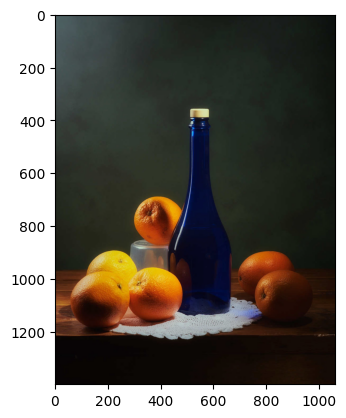

In [2]:
image = cv.imread('bottle.jpg')
scale_percent = 100
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv.resize(image, dim, interpolation = cv.INTER_AREA)
image_rgb = cv.cvtColor(resized, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [3]:
def auto_segment(x1, y1, x2, y2, threshold):
    image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)
    # определяем координаты начальных точек
    seeds = [(x1, y1), (x2, y2)]
    # координаты для графика
    x = list(map(lambda x: x[1], seeds))
    y = list(map(lambda x: x[0], seeds))
    # находим сегментацию используя метод из segmentation_utils
    segmented_region = utility.region_growingHSV(image_hsv, seeds, threshold)
    # накладываем маску - отображаем только участки попавшие в какой-либо сегмент
    result = cv.bitwise_and(image_rgb, image_rgb, mask=segmented_region)
    # отображаем полученное изображение
    plt.figure(figsize=(15,20))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, marker="x", color="red", s=200)
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
interact(auto_segment, x1=500, y1=540, x2=1000, y2=540, threshold=110)

interactive(children=(IntSlider(value=500, description='x1', max=1500, min=-500), IntSlider(value=540, descrip…

<function __main__.auto_segment(x1, y1, x2, y2, threshold)>

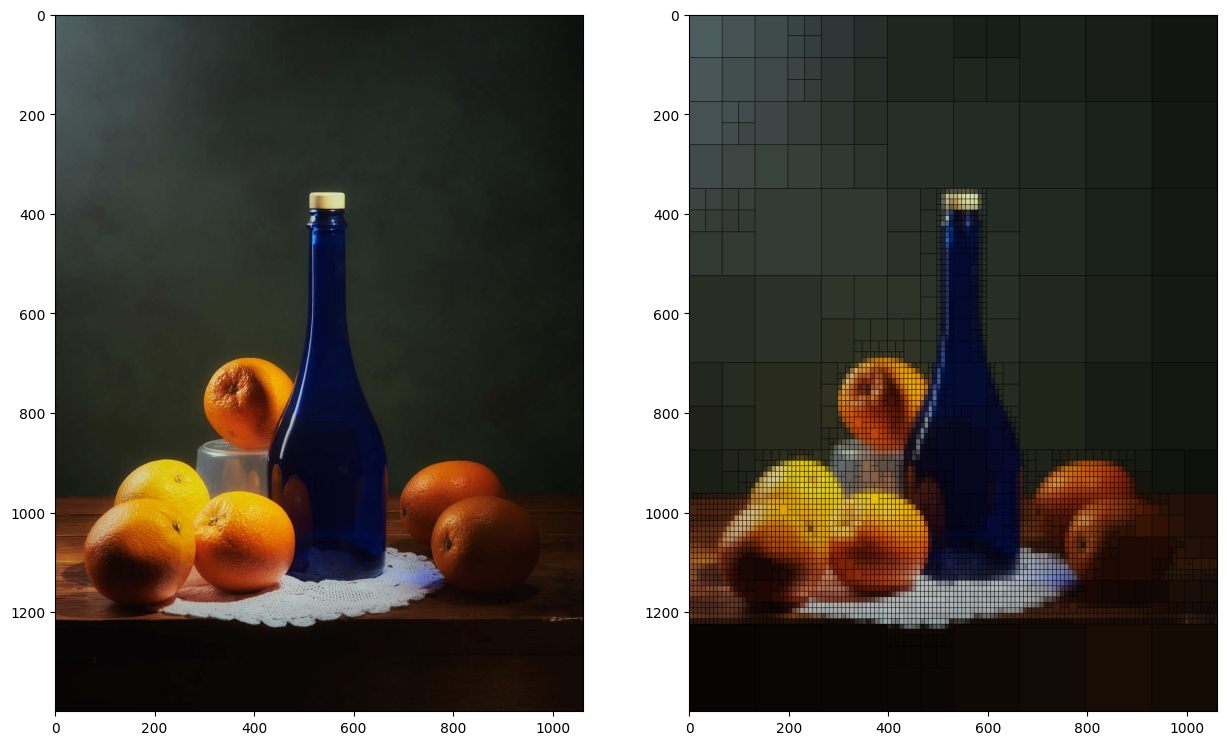

In [6]:
qt = utility.QTree(stdThreshold = 0.25, minPixelSize = 4,img = image_rgb.copy()) 
qt.subdivide()
tree_image = qt.render_img(thickness=1, color=(0,0,0))

plt.figure(figsize=(15,20))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.subplot(1, 2, 2)
plt.imshow(tree_image)
plt.show()


In [7]:
gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)



In [8]:
from skimage.segmentation import watershed
from scipy import ndimage
from skimage.feature import peak_local_max

C:\Users\Andrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 44]
 [184]
 [ 21]
 [ 99]
 [ 58]
 [ 32]
 [158]
 [126]
 [ 10]
 [ 75]]


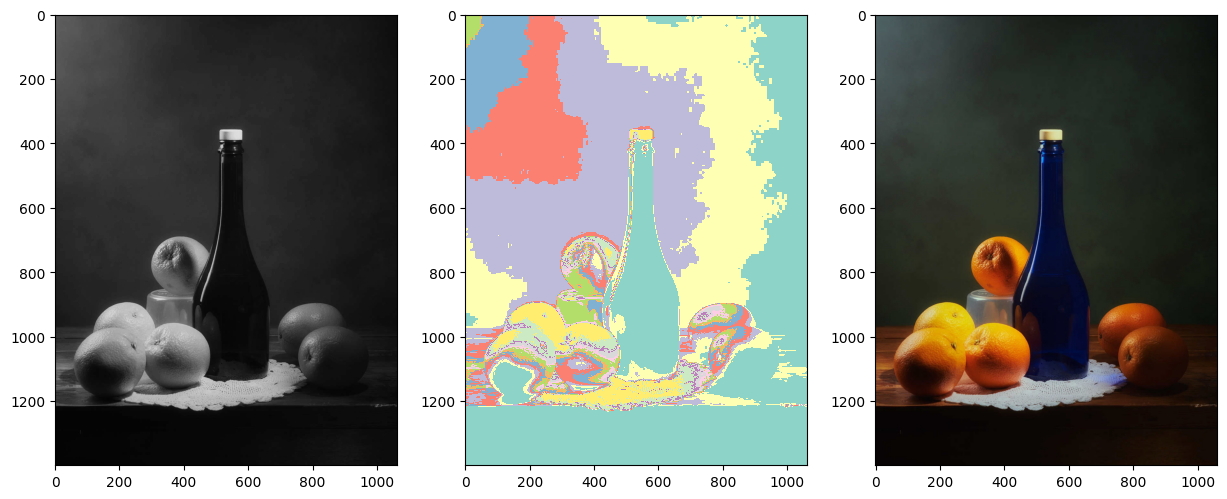

In [9]:
from sklearn.cluster import KMeans
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 10
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
# Удалим самые яркие пиксели
segments[(segments==124) | (segments==94) | (segments==41) | (segments==159) | (segments==53) | (segments==20) | (segments==30)| (segments==185) | (segments==70)] = 0
result = cv.bitwise_and(image_rgb, image_rgb, mask=segments)
# Отобразим избражения 
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.show()

In [10]:
from sklearn.cluster import MeanShift, estimate_bandwidth
blur_image = cv.medianBlur(image_rgb, 9)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_

# получим количество сегментов
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image_rgb.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]

Number of segments:  23


[[     7  88144]
 [    11     34]
 [    12     29]
 [    13    121]
 [    15     48]
 [    20 436046]
 [    29   2437]
 [    38 671410]
 [    65  85173]
 [    79    656]
 [    96  10057]
 [   111  56201]
 [   125   3913]
 [   142   8002]
 [   161   4192]
 [   168  29409]
 [   177  36089]
 [   199  11735]
 [   209   4523]
 [   213   1401]
 [   221   5693]
 [   224  19425]
 [   228  12062]]


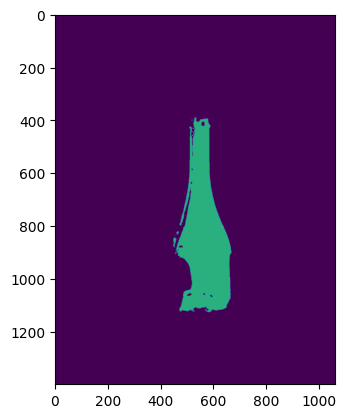

In [11]:
mask2=mask1.copy()
unique, counts = np.unique(mask2, return_counts=True)
print(np.asarray((unique, counts)).T)
mask2[(mask2==224)
      | (mask2==228)
      | (mask2==12)
     | (mask2==13)
     | (mask2==15)
     | (mask2==20)
     | (mask2==29)
     | (mask2==38)
     | (mask2==65)
     | (mask2==79)
     | (mask2==96)
     | (mask2==111)
     | (mask2==125)
     | (mask2==142)
     | (mask2==161)
     | (mask2==168)
     | (mask2==177)
     | (mask2==199)
     | (mask2==209)
     | (mask2==213)
     | (mask2==221)
     | (mask2==0)
     | (mask2==0)]= 0
plt.imshow(mask2)

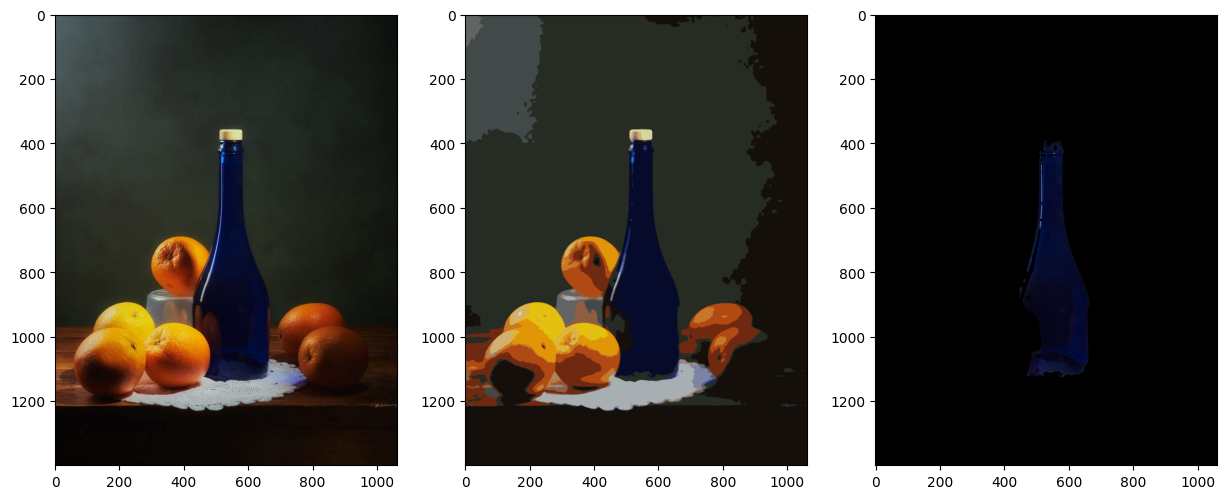

In [12]:
mean_shift_with_mask_image = cv.bitwise_and(image_rgb, image_rgb, mask=mask2)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(mean_shift_with_mask_image)
plt.show()